# Assignemnt part 2:
In this assignment we build Self organising maps and explore them. 

## Topological ordering of animal species
We are given a dataset of animal species and their features. We are to build a self organising map and use it to find the topological ordering of the animal species. The data is from animals.dat 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

[(72, 'antelop'), (7, 'ape'), (37, 'bat'), (13, 'bear'), (0, 'beetle'), (0, 'butterfly'), (84, 'camel'), (27, 'cat'), (3, 'crocodile'), (19, 'dog'), (0, 'dragonfly'), (1, 'duck'), (44, 'elephant'), (5, 'frog'), (78, 'giraffe'), (0, 'grasshopper'), (99, 'horse'), (0, 'housefly'), (16, 'hyena'), (65, 'kangaroo'), (32, 'lion'), (0, 'moskito'), (1, 'ostrich'), (1, 'pelican'), (1, 'penguin'), (91, 'pig'), (58, 'rabbit'), (51, 'rat'), (2, 'seaturtle'), (23, 'skunk'), (0, 'spider'), (10, 'walrus')]


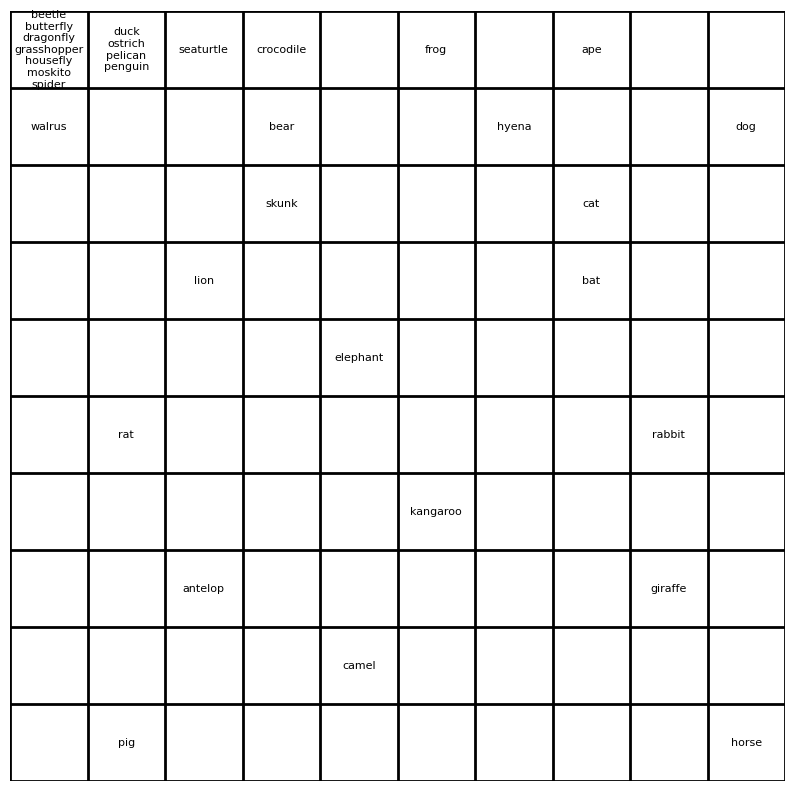

In [39]:
# Initialize the weights
weights = np.random.rand(100, 84)
weights = np.random.uniform(0, 1, (100, 84))


# Load the data
def load_data():

    # Load the data and conver into 32 x 84
    animals = np.genfromtxt("Dataset/animals.dat", delimiter=",")
    animals = animals.reshape(32, 84)

    file = open("Dataset/animalnames.txt", "r")
    animalnames = file.read().splitlines()
    # remove the "'" and \t from the animalnames
    animalnames = [x.replace("'", "") for x in animalnames]
    animalnames = [x.replace("\t", "") for x in animalnames]
    file.close()

    return animals, animalnames


def SOM(dataset, epochs, weights, initial_neighbours=50, learning_rate=0.2):
    n_samples = dataset.shape[0]
    n_nodes = weights.shape[0]
    real_distance = initial_neighbours  # Start with the initial neighborhood size

    for epoch in range(epochs):
        # Decrease the neighborhood size over time without rounding
        real_distance -= (initial_neighbours - 1) / epochs
        # Use the rounded value for the neighborhood calculation
        neighbours_left = round(real_distance)

        for sample in range(n_samples):
            # Compute the minimum node (winner)
            distance = np.linalg.norm(dataset[sample, :] - weights, axis=1)
            winner = np.argmin(distance)

            # Compute the neighbourhood boundaries
            min_neighbour = int(max(0, winner - neighbours_left))
            max_neighbour = int(min(n_nodes, winner + neighbours_left))

            # Update the weights for nodes within the neighborhood
            for node in range(min_neighbour, max_neighbour):
                weights[node] += learning_rate * (dataset[sample] - weights[node])

    return weights


def find_winners(dataset, weights):
    """
    Loops through each sample in the dataset, finds the winning node in the SOM,
    and returns a list of indices corresponding to the winning node for each sample.
    """
    n_samples = dataset.shape[0]
    n_nodes = weights.shape[0]
    distance = np.zeros(n_nodes)
    winners = []

    for sample in range(n_samples):
        # Compute the distance from the sample to each node's weights
        for node in range(n_nodes):
            distance[node] = np.linalg.norm(dataset[sample, :] - weights[node, :])
        # Find the winning node
        winner = np.argmin(distance)
        winners.append(winner)

    return winners


def visualize_animal_SOM(winners_with_names, grid_size=(10, 10)):
    """
    Visualize the SOM grid with each node displaying the corresponding animal(s).

    :param winners_with_names: A list of tuples (node, animal_name).
    :param grid_size: A tuple (rows, cols) representing the size of the SOM grid.
    """
    # Create a dictionary where each key is a node and each value is a list of animals for that node
    node_animals = {}
    for node, animal in winners_with_names:
        if node not in node_animals:
            node_animals[node] = []
        node_animals[node].append(animal)

    # Calculate the number of rows and columns for the grid
    rows, cols = grid_size

    # Create the plot
    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.set_xlim([0, cols])
    ax.set_ylim([0, rows])
    ax.invert_yaxis()  # Invert the y-axis so the first row starts at the top

    # Remove the axes
    plt.axis("off")

    # Add animals to the nodes in the grid
    for node, animals in node_animals.items():
        x = node % cols
        y = node // cols
        ax.text(
            x + 0.5, y + 0.5, "\n".join(animals), ha="center", va="center", fontsize=8
        )

    # Draw grid lines
    for x in range(cols + 1):
        ax.axvline(x, lw=2, color="k", zorder=5)
    for y in range(rows + 1):
        ax.axhline(y, lw=2, color="k", zorder=5)

    # Show the SOM grid
    plt.show()


# Load the data
animal, animalnames = load_data()

# Train the SOM
weights = SOM(animal, 1000, weights)

# Find the winners
winners = find_winners(animal, weights)


# Create tuple of each winning node index with the corresponding animal name
winners_with_names = [(win, animalnames[idx]) for idx, win in enumerate(winners)]
print(winners_with_names)

# Visualise the SOM grid
visualize_animal_SOM(winners_with_names, grid_size=(10, 10))

## Cyclic tor:
Here we are to solve TSP using a self organising map. We are given a dataset of 30 cities and their coordinates. We are to build a self organising map and use it to find the shortest path that visits all the cities. The data is from cities.dat

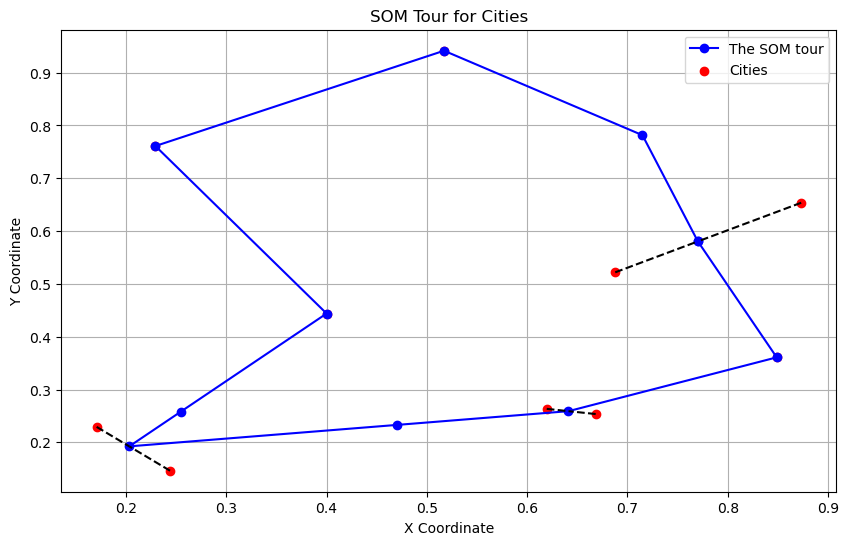

In [40]:
def load_cities_data(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Skip comment lines
            if line.startswith("%"):
                continue
            # Strip semicolons and newlines, then split by comma
            stripped_line = line.strip(";\n")
            if stripped_line:  # Check if the line is not empty
                split_line = stripped_line.split(",")
                # Convert the split values to float and append to data list
                data.append([float(value.strip()) for value in split_line])
    return np.array(data)


# 10 weights for each city normalized between 0 and 1
weights_cities = np.random.uniform(0, 1, (10, 2))


# Plots the SOM tour for the cities
def plot_som_tour(cities, weights):
    # Create a closed loop by adding the first node to the end
    tour = np.vstack([weights, weights[0]])

    plt.figure(figsize=(10, 6))
    plt.plot(tour[:, 0], tour[:, 1], "b-o", label="The SOM tour")
    plt.scatter(cities[:, 0], cities[:, 1], color="red", label="Cities")

    # Connect the SOM nodes to the cities they represent
    for i, city in enumerate(cities):
        closest_node_idx = np.argmin(np.linalg.norm(weights - city, axis=1))
        plt.plot(
            [city[0], weights[closest_node_idx, 0]],
            [city[1], weights[closest_node_idx, 1]],
            "k--",
        )

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("SOM Tour for Cities")
    plt.legend()
    plt.grid(True)
    plt.show()


def SOM_cities(dataset, epochs, weights, learning_rate=0.2):
    n_samples = dataset.shape[0]
    n_nodes = weights.shape[0]

    # Start with a neighborhood of 2, then go to 1, then to 0
    neighborhood_sizes = [2, 1, 0]
    neighborhood_size = neighborhood_sizes[0]

    for epoch in range(epochs):
        # Decrease neighborhood size at specified epochs
        if epoch == int(epochs / 3):
            neighborhood_size = neighborhood_sizes[1]
        elif epoch == int(2 * epochs / 3):
            neighborhood_size = neighborhood_sizes[2]

        for sample in range(n_samples):
            # Find the winning node
            distance = np.linalg.norm(dataset[sample, :] - weights, axis=1)
            winner = np.argmin(distance)

            # Update weights for the winning node and its neighbors
            for neighbor in range(-neighborhood_size, neighborhood_size + 1):
                neighbor_idx = (winner + neighbor) % n_nodes
                weights[neighbor_idx] += learning_rate * (
                    dataset[sample] - weights[neighbor_idx]
                )

    return weights


# Load cities data
cities = load_cities_data("Dataset/cities.dat")
# Train the SOM
weights_cities = SOM_cities(cities, 200, weights_cities)
# Visualise it
plot_som_tour(cities, weights_cities)

### Political classification 
Here we are given data about how all the 349 memebrs of the Swedish parliament voted on the first 31 first votes during 2004-2005. There are also additional files *mpparty.dat*, *mpsex.dat* and *mpdistrict.dat* that contain informations about the party, gender and district of each mumber of the MP. Lastly there is a file *mpnames.txt* with the names of the MPs. 

Use SOM algorithm to position all MPs on a 10x10 grid according to their voting. By looking at where the different parties end up in the map, you should be able to see if votes of the MPs actually reflect the traditional left-right division in the Swedish parliament.

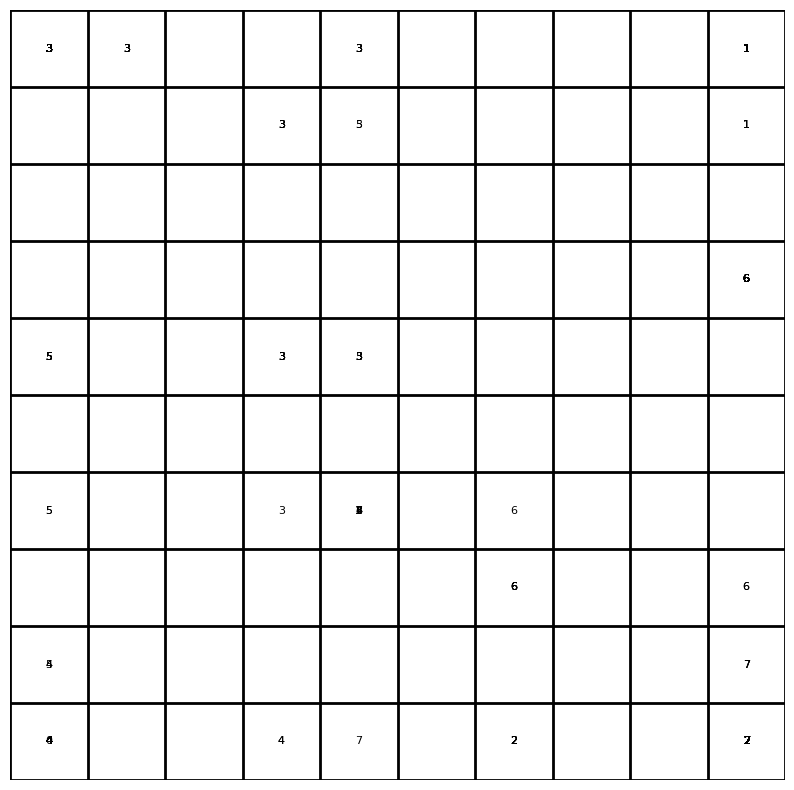

                     Name  Female?  Party  District Winning node
0       Skårman Carl-Erik        0      1         1       (9, 0)
1         Romanus Gabriel        0      2         1       (9, 9)
2         Odenberg Mikael        0      1         1       (9, 0)
3         Järrel Henrik S        0      1         1       (9, 0)
4         Lindgren Sylvia        1      3         1       (0, 0)
..                    ...      ...    ...       ...          ...
344          Åström Karin        1      3        29       (0, 0)
345      Gidblom Birgitta        1      3        29       (0, 0)
346           Öberg Maria        1      3        29       (0, 0)
347   Hammarbergh Krister        0      1        29       (9, 0)
348  Grönlund Krantz Anna        1      2        29       (9, 9)

[349 rows x 5 columns]


In [87]:
import pandas as pd
# Start off by reading the data

def read_dataset():
    # Read the votes data
    votes = np.genfromtxt("Dataset/votes.dat", delimiter=",").reshape(349, 31)

    # Import gender, read from line 3 to 351
    gender = pd.read_csv("Dataset/mpsex.dat", header=None, skiprows=2, nrows=349) 

    # Import party, read from line 4 to 352
    party = pd.read_csv("Dataset/mpparty.dat", header=None, skiprows=3, nrows=349)

    # Import names
    names = pd.read_csv("Dataset/mpnames.txt", header=None, encoding="iso-8859-1")

    # Import districts
    districts = pd.read_csv("Dataset/mpdistrict.dat", header=None)

    frames = [names,gender,party,districts]

    # Insert header names
    names.columns = ["Name"]
    gender.columns = ["Female?"]
    party.columns = ["Party"]
    districts.columns = ["District"]

    # Concatenate the dataframes
    result = pd.concat(frames, axis=1)

    votes.reshape(349, 31)

    return votes, result


# Train the SOM
def SOM_politics(votes, attributes, epochs, weights, learning_rate=0.2):
    neighbor_size = 5
    for epoch in range(epochs):
        for sample in range(votes.shape[0]):
            # Find the winning node using the euclidean distance
            distance = np.linalg.norm(votes[sample, :] - weights, axis=2)
            winner = np.unravel_index(np.argmin(distance, axis=None), distance.shape)

            # Update weights for the winning node and its neighbors
            for i in range(
                max(0, winner[0] - neighbor_size),
                min(weights.shape[0], winner[0] + neighbor_size + 1),
            ):
                for j in range(
                    max(0, winner[1] - neighbor_size),
                    min(weights.shape[1], winner[1] + neighbor_size + 1),
                ):
                    # Checks if the node is within the grid boundaries before updating
                    weights[i, j] += learning_rate * (votes[sample] - weights[i, j])


    # Find the winning node for each sample
    winners_indices = np.array(
        [
            np.unravel_index(
                np.argmin(
                    np.linalg.norm(votes[sample, :] - weights, axis=2), axis=None
                ),
                distance.shape,
            )
            for sample in range(votes.shape[0])
        ]
    )

    # Convert the winning node indices to a 2D coordinate on the SOM grid
    winners_coordinates = [(winner[0], winner[1]) for winner in winners_indices]

    # Create a column called "Winning node" and add it to the attributes dataframe
    attributes["Winning node"] = winners_coordinates

    return attributes

# Visualise the SOM grid
def visualize_politics(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
    ax.invert_yaxis()  # Invert the y-axis so the first row starts at the top

    # Remove the axes
    plt.axis("off")

    # Add animals to the nodes in the grid
    for index, row in data.iterrows():
        x, y = row["Winning node"]
        ax.text(
            x + 0.5, y + 0.5, row["Party"], ha="center", va="center", fontsize=8
        )

    # Draw grid lines
    for x in range(11):
        ax.axvline(x, lw=2, color="k", zorder=5)
    for y in range(11):
        ax.axhline(y, lw=2, color="k", zorder=5)

    # Show the SOM grid
    plt.show()



# Read the data
votes, result = read_dataset()
# Initialize the weights
weight = np.random.rand(10, 10, 31)

# Train the SOM
winners = SOM_politics(votes, result, 1000, weight)
visualize_politics(winners)


print(winners)